In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import Table

from scipy.optimize import minimize, Bounds

from DRP_rotation_curve import extract_data, extract_Pipe3d_data

from disk_mass import calc_mass_curve, fit_mass_curve

from rotation_fitfunctions import find_phi, find_axis_ratio, find_incl, parameterfit_iso, parameterfit_NFW, parameterfit_bur, chi2

from rotation_curve_functions import disk_bulge_vel, halo_vel_NFW, bulge_vel, disk_vel

import RC_plotting_functions as RC#import plot_diagnostic_panel

import matplotlib.pyplot as plt



In [2]:
#import sys
#sys.path.insert(1,"main/")
from Velocity_Map_Functions_cython import rot_incl_iso, rot_incl_bur, rot_incl_NFW
from galaxy_component_functions_cython import vel_tot_iso, halo_vel_iso, disk_vel, bulge_vel

In [21]:
import importlib
import rotation_fitfunctions
#import rotation_curve_functions
#import galaxy_component_functions_cython
#importlib.reload(galaxy_component_functions_cython)
importlib.reload(rotation_fitfunctions)
#importlib.reload(rotation_curve_functions)

<module 'rotation_fitfunctions' from '/gpfs/fs1/home/lstroud3/Documents/RotationCurve/2D_RC/rotation_fitfunctions.py'>

In [3]:
gal_ID = '10220-12703' 
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s
fit_function = 'bulge'


In [4]:
#MASS_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\pipe3d\v3_1_1\3.1.1\7443"
#VEL_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\analysis\v3_1_1\3.1.0\HYB10-MILESHC-MASTARSSP\7443\12705"
#DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"

MANGA_FOLDER = '/scratch/kdougla7/data/SDSS/dr17/manga/spectro/'
MASS_MAP_FOLDER = MANGA_FOLDER + 'pipe3d/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/' + 'drpall-v3_1_1.fits'

In [5]:
DRP_table = Table.read( DRP_FILENAME, 'MANGA')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [27]:
# Extract data
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)

i_DRP = DRP_index[gal_ID]

# Locate and save photometric parameters
axis_ratio = DRP_table['nsa_elpetro_ba'][i_DRP]
incl = find_incl(axis_ratio)

phi = DRP_table['nsa_elpetro_phi'][i_DRP]

print(incl)
print(phi)

z = DRP_table['nsa_z'][i_DRP]
print(z)

# Create S/N > 5 mask
SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
map_mask = maps['Ha_vel_mask'] + (SN_map < 5)

# Mask the velocity map with the S/N > 5 mask
maps['vmasked'] = ma.array(maps['Ha_vel'], mask=map_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=map_mask)

shape = maps['vmasked'].shape

# Calculate the scale of the pixels
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc
"""
center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x_center = center[0]
y_center = center[1]


param = [-1,10,incl, phi, x_center, y_center,0]
print(phi)
print(axis_ratio) """
center = (37,37)
print(center)
phi = find_phi(center, phi, maps['vmasked'])
x_center = center[0]
y_center = center[1]

0.7632232119047914
6.40918
0.0171688
(37, 37)
3.8108714
(37, 37)
0.11186129335297018


0.33581144665127866
2274.7784489490964


'\n8997-9102: 4312, 408\n8985-9102: 2791, 434\n7443-12705: 421, 1299'

In [28]:
#0.11259096400658039, 0.7257461163584406, 35.49489300431426, 36.873046417018436
mass_data_table = calc_mass_curve(sMass_density,
                                  sMass_density_err,
                                  maps['r_band'],
                                  maps['Ha_vel_mask'],
                                  x_center,
                                  y_center,
                                  axis_ratio,
                                  phi,
                                  z,
                                  gal_ID)

print(gal_ID, "mass curve calculated")

finding mass curve
10220-12703 mass curve calculated


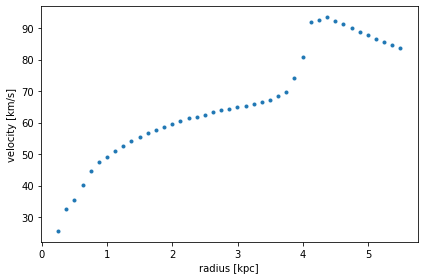

In [29]:
plt.figure(tight_layout=True)

plt.plot(mass_data_table['radius'], 
         mass_data_table['star_vel'], 
         '.')

plt.xlabel('radius [kpc]')
plt.ylabel('velocity [km/s]');

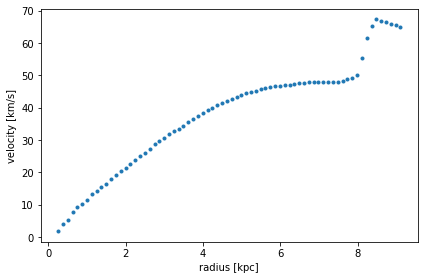

In [24]:
plt.figure(tight_layout=True)

plt.plot(mass_data_table['radius'], 
         mass_data_table['star_vel'], 
         '.')

plt.xlabel('radius [kpc]')
plt.ylabel('velocity [km/s]');

In [25]:
print(mass_data_table['radius','star_vel'])

       radius            star_vel     
------------------- ------------------
0.24953732275366963 1.8233474429631154
 0.3743059841305044  4.021090583328307
0.49907464550733927  5.326564212577938
 0.6238433068841741  7.697121104624685
 0.7486119682610088  9.198365864667133
 0.8733806296378437 10.344094890344874
 0.9981492910146785 11.472783191289462
 1.1229179523915134 13.177978006335774
 1.2476866137683482 14.127124057376276
  1.372455275145183 15.391688163436772
                ...                ...
  7.860425666740594  49.14872146351232
  7.985194328117428 50.224901480709434
  8.109962989494264  55.39574928139302
  8.234731650871097  61.37263987596594
  8.359500312247933  65.11237160680686
  8.484268973624767  67.28897519055604
  8.609037635001602  66.80545590656709
  8.733806296378438  66.32741948003574
  8.858574957755271  65.85866860708302
  8.983343619132107  65.39971759712968
   9.10811228050894  64.95022967921486
Length = 72 rows


In [9]:
print(mass_data_table['radius','star_vel'])

       radius            star_vel     
------------------- ------------------
0.47350291273319034  125.5315618617676
 0.7102543690997856 158.45291584454955
 0.9470058254663807 167.75299358668352
 1.1837572818329758 174.08480307209345
 1.4205087381995711 175.72396872482395
 1.6572601945661662 173.62442101617316
 1.8940116509327614 171.13491891783372
 2.1307631072993565   167.647122752163
 2.3675145636659516  165.3187789884425
 2.6042660200325467   162.676947821794
                ...                ...
  5.208532040065093 135.44278530798064
 5.4452834964316885 133.46942037581772
 5.6820349527982845 131.59496244745964
   5.91878640916488 129.64111014457978
  6.155537865531475 127.70832586507325
   6.39228932189807 125.66292669385217
  6.629040778264665 123.63848437504998
   6.86579223463126 121.60531038157205
  7.102543690997855 119.61722419038057
   7.33929514736445 117.70185764963851
  7.576046603731045 115.85282113680543
Length = 31 rows


In [26]:
param_outputs = fit_mass_curve(mass_data_table,
                               gal_ID,
                               fit_function, 
                               #IMAGE_DIR=r"C:\Users\Lara\Documents\rotationcurves", 
                               #IMAGE_FORMAT='png'
                              )
print(param_outputs)

{'Sigma_disk': 1.251112728964954e-10, 'Sigma_disk_err': 8.34907400821894, 'R_disk': 9.999999999085293, 'R_disk_err': 0.0, 'rho_bulge': 0.007864165858398315, 'rho_bulge_err': 0.0019727701987404473, 'R_bulge': 5.416757551047781, 'R_bulge_err': 0.6286193429945173, 'chi2_disk': 69901757.30234283}


In [10]:
from scipy.optimize import curve_fit

help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``.
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N). If None, then the
        initi

In [8]:
SigD = param_outputs["Sigma_disk"]
Rd = param_outputs["R_disk"]
rho_bulge = param_outputs["rho_bulge"]
R_bulge = param_outputs["R_bulge"]
print(rho_bulge)

0.2419028963905668


In [ ]:
best_fit_test = parameterfit_bur(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask,gal_ID)

In [14]:
print(best_fit_test)

(array([-1.26967872,  9.12301784,  0.87563658,  5.35510691, 32.82411134,
       32.01927596, 16.10649245]), array([0.00768393, 0.11773068, 0.00247693, 0.00071326, 0.01715796,
       0.01473133, 0.14464613]))


In [33]:
best_fit_NFW = parameterfit_NFW(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask,gal_ID)

In [34]:
best_fit_bur =parameterfit_bur(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask,gal_ID)

In [35]:
best_fit_iso =parameterfit_iso(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask,gal_ID)

In [37]:
print(best_fit_NFW[1],best_fit_bur[1],best_fit_iso[1])

[2.60616089e-02 2.17832202e+00 3.50594116e-03 8.74740863e-04
 1.62680679e-02 1.52049084e-02 1.00824681e-01] [4.21275148e-03 2.12273968e+01 2.06278288e-03 7.32171772e-04
 1.09282414e-02 1.09230783e-02 9.06562810e-02] [1.00520430e-02 1.02927111e+00 3.92506623e-03 7.68403086e-04
 1.20345197e-02 1.10941084e-02 9.26060585e-02]


In [332]:



iso_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_iso[0],best_fit_iso[1],best_fit_iso[2],best_fit_iso[3],best_fit_iso[4],best_fit_iso[5],best_fit_iso[6]]
NFW_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_NFW[0],best_fit_NFW[1],best_fit_NFW[2],best_fit_NFW[3],best_fit_NFW[4],best_fit_NFW[5],best_fit_NFW[6]]
bur_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur[0],best_fit_bur[1],best_fit_bur[2],best_fit_bur[3],best_fit_bur[4],best_fit_bur[5],best_fit_bur[6]]

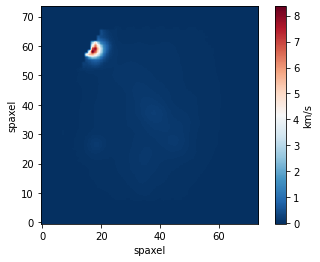

In [17]:
plt.imshow(maps["r_band"], 
           origin='lower', 
           cmap='RdBu_r')

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
#plt.title('7443-12705 Velocity Map')
#plt.savefig("7443-12705_data")
#5.405721025739437, 0.859223

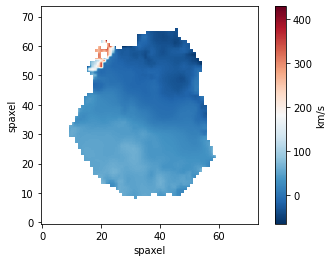

In [23]:
plt.imshow(maps["vmasked"], 
           origin='lower', 
           cmap='RdBu_r')

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')
#plt.title('7443-12705 Velocity Map')
#plt.savefig("7443-12705_data")
#5.2667753639881685, 0.617652

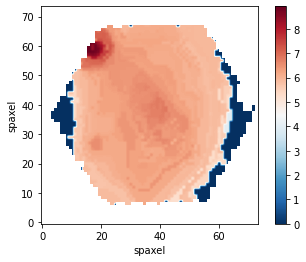

In [22]:
plt.imshow(sMass_density, 
           origin='lower', 
           cmap='RdBu_r')

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
#cbar.set_label('km/s')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iso: [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, -1.1004383291657658, 3.1034411951560106, 1.0753930641967842, 0.699932808737459, 36.60702475726927, 37.68059851207151, 13.951800854854437]
216.1523606396317
NFW [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, -2.251955407489212, 25.502658833876982, 1.0759555322501546, 0.6990559321300809, 36.59462611334587, 37.68595223377552, 14.179451252970935]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


220.16661176058827
Bur: [120050641.10390615, 2.73444270675828, 651.0289797724238, 0.903804192022047, -1.0939294679703189, 5.478764398065083, 1.0758183565458606, 0.7002491653719471, 36.62910970880082, 37.6821848135174, 13.757226286920673]
214.45686244725545


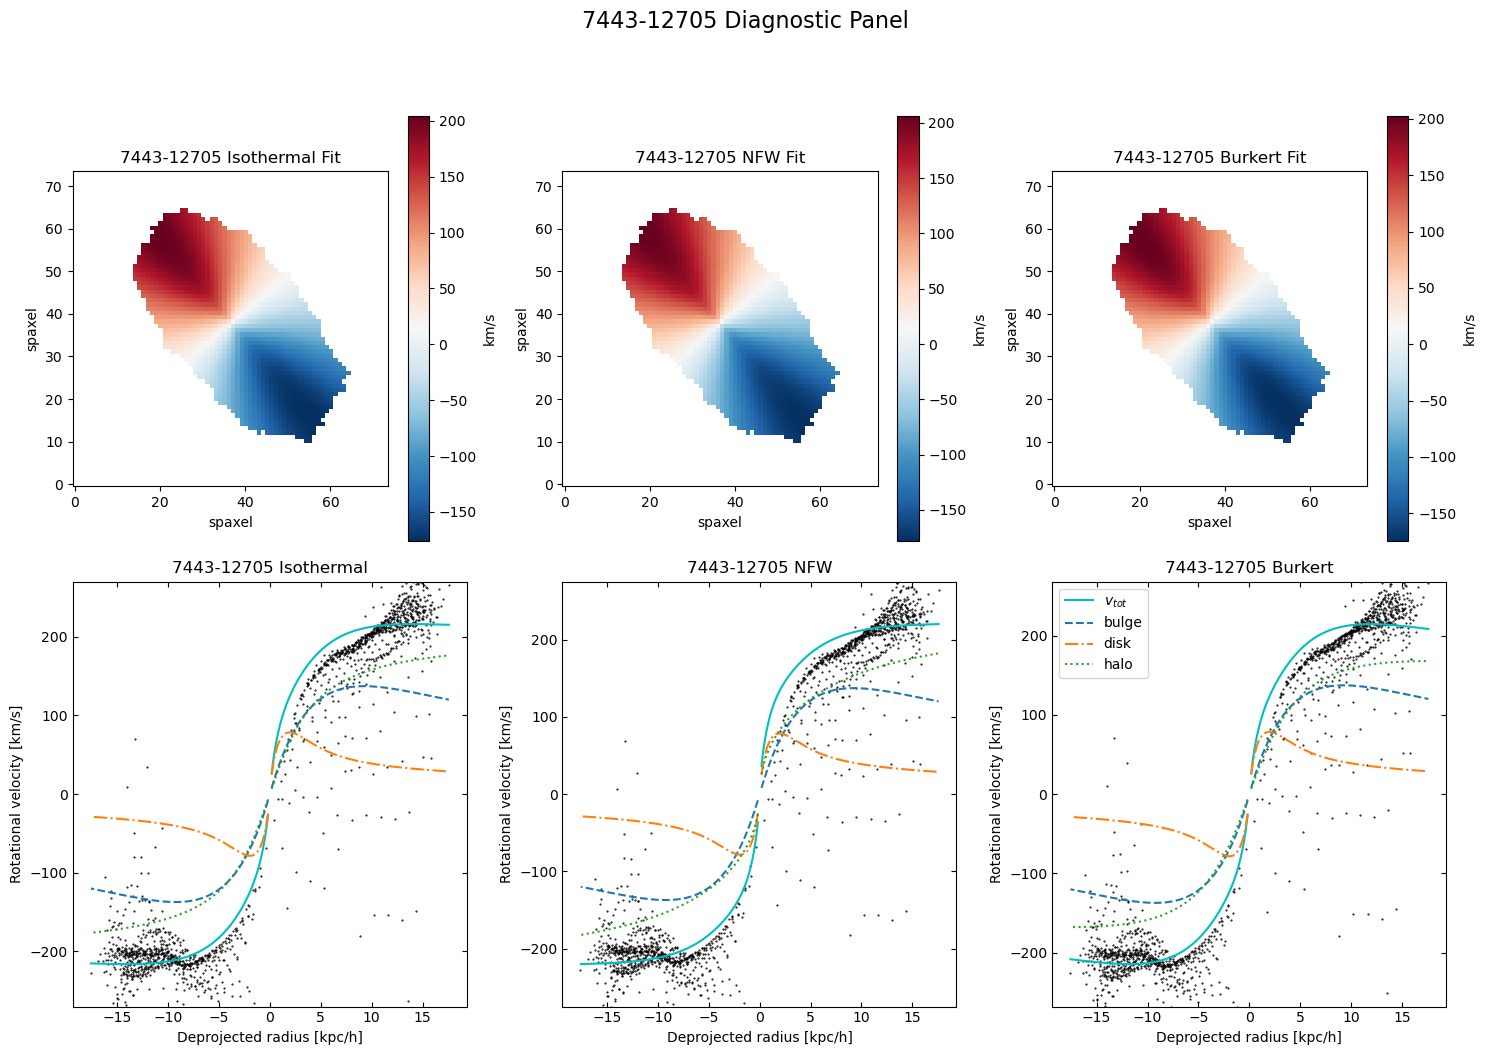

In [428]:
RC.plot_diagnostic_panel(gal_ID, shape, scale, iso_fit, NFW_fit, bur_fit, map_mask, maps['vmasked'],maps['ivarmasked'])


In [98]:
#NFW: -2,35  ISO: -1.2, 10, Bur: -1.5, 40

214.45686244725545


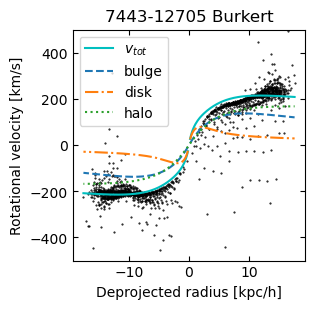

In [426]:
bur_test=[rho_bulge, R_bulge,SigD, Rd, -1.5, 40,incl,phi,37,37,23]
RC.plot_rot_curve(maps['vmasked'],maps['ivarmasked'], bur_fit,scale,gal_ID,'Burkert')
plt.gca().set_ylim(-500,500);
#plt.gca().set_xlim(-15,15);

In [330]:
best_fit_NFW_test = parameterfit_NFW(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:229: RuntimeWarning: invalid value encountered in double_scalars
  vel = np.sqrt(coeff_2 * F / r)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:347: RuntimeWarning: invalid value encountered in double_scalars
  bessel_component = (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y))
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:590: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:589: RuntimeWarning: invalid value encountered in log
  halo_mass = 4*np.pi*rho0_h*Rh**3*((-r/(Rh+r)) + np.log(Rh + r) - np.log(Rh))


---------------------------------------------------
   direc: array([[ 0.00000000e+00,  1.06070667e-02,  0.00000000e+00,
         5.38230240e-03,  1.10883613e-01, -2.71081915e-01,
        -1.53298163e+00],
       [-4.23716294e-04, -3.94276204e-02, -3.27664990e-03,
         3.57646402e-03,  6.26768013e-02,  1.90320816e-02,
        -5.09545546e-02],
       [-3.94616607e-02,  6.70636362e-01,  4.35956599e-02,
         1.07462805e-02, -1.39324072e-01,  3.30150140e-01,
         3.01929128e+00],
       [-1.16836055e-02,  8.71408549e-02,  4.17192866e-03,
        -3.16928175e-03,  8.33271853e-02,  6.85325535e-02,
         5.31322728e-02],
       [-7.04177459e-02,  8.04881806e-01,  4.55960754e-02,
        -1.67164562e-02,  1.23652649e-02, -1.39182562e-01,
        -1.57163273e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 2.15104383e-03, -1.18508482e-01, -8.14283800e-03,
         8.5832

In [336]:
NFW_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_NFW_test[0],best_fit_NFW_test[1],best_fit_NFW_test[2],best_fit_NFW_test[3],best_fit_NFW_test[4],best_fit_NFW_test[5],best_fit_NFW_test[6]]

In [427]:
print("Isothermal Chi2:", chi2(maps['vmasked'],maps['ivarmasked'], map_mask, shape, scale, iso_fit, "Isothermal"))
print("NFW Chi2:", chi2(maps['vmasked'],maps['ivarmasked'], map_mask, shape, scale, NFW_fit, "NFW"))
print("Burkert Chi2:", chi2(maps['vmasked'],maps['ivarmasked'], map_mask, shape, scale, bur_fit, "Burkert"))

Isothermal Chi2: (29354.89728904651, 18.508762477330713)
NFW Chi2: (31523.74911715107, 19.876260477396638)
Burkert Chi2: (30613.352174573352, 19.302239706540576)


In [413]:
best_fit_iso_test = parameterfit_iso(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

1.3432236922176852
[[-7, 2], [1, 1000], [0.8196249166193864, 1.4451326206513049], [0, 6.911503837897546], [32, 42], [32, 42], [-100, 100]]
---------------------------------------------------
   direc: array([[-4.48490906e-03,  4.96552570e-03,  7.59833432e-03,
         1.12387303e-02, -3.65443428e-02, -2.94526481e-01,
        -1.21517136e+00],
       [-1.35410892e-02,  7.24475265e-02, -7.58216255e-05,
         2.67075289e-03, -7.28732820e-03,  3.75344619e-04,
         8.04791084e-02],
       [-2.06225741e-02,  1.37016557e-02,  2.22917613e-02,
         6.79109796e-03,  1.45732405e-01,  1.65743545e-01,
         4.77799133e-01],
       [-7.31255204e-02,  3.17714654e-01,  1.28058545e-02,
        -3.15443564e-03,  9.02923358e-02, -9.26043500e-02,
        -1.22140102e+00],
       [-3.58775305e-02,  1.44959693e-01, -1.86920419e-02,
        -8.74138335e-04,  1.15008277e-02, -8.40872726e-02,
        -2.60101590e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e

In [414]:
iso_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_iso_test[0],best_fit_iso_test[1],best_fit_iso_test[2],best_fit_iso_test[3],best_fit_iso_test[4],best_fit_iso_test[5],best_fit_iso_test[6]]

In [424]:
best_fit_bur_test = parameterfit_bur(param, rho_bulge, R_bulge,
                                        SigD, Rd, scale, shape,
                                        maps['vmasked'], maps['ivarmasked'], map_mask)

C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:672: RuntimeWarning: invalid value encountered in double_scalars
  vel2 = G * (halo_mass * Msun) / (r * 3.08E16)
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:669: RuntimeWarning: invalid value encountered in log
  halo_mass = np.pi * (-rho0_h) * (Rh**3) * (-np.log(Rh**2 + r**2) - 2*np.log(Rh + r) + 2*np.arctan2(r,Rh) + np.log(Rh**2)\
C:\Users\Lara\Documents\rotationcurves\rotation_curve_functions.py:670: RuntimeWarning: invalid value encountered in log
  + 2*np.log(Rh) - 2*np.arctan2(0,Rh))


---------------------------------------------------
   direc: array([[-1.48225392e-01,  3.90667645e-01,  1.40943238e-02,
         3.78988554e-03,  6.45125740e-01, -2.52322461e-01,
        -5.19462302e+00],
       [-1.81457951e-01,  5.56634361e-01,  4.98594141e-03,
        -6.88598468e-03, -3.27750597e-01, -2.02714847e-02,
         4.63673667e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.00131527e-01,  6.50904372e-01,  1.88978947e-02,
        -6.82602928e-03,  2.06876138e-01, -1.28805123e-01,
        -2.64263786e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.99326598e-02,  1.51389836e-01,  5.02417225e-03,
         2.9167

In [425]:
bur_fit = [param_outputs['rho_bulge'], param_outputs['R_bulge'], param_outputs['Sigma_disk'],
               param_outputs['R_disk'],best_fit_bur_test[0],best_fit_bur_test[1],best_fit_bur_test[2],best_fit_bur_test[3],best_fit_bur_test[4],best_fit_bur_test[5],best_fit_bur_test[6]]

In [5]:
import combin_fit_functions

In [11]:
para = [-0.946349642078173, 2.772746756396145, 421.1367144741646, 1.2061752844906461, -3.562305898749054, 382.58404523885497, 1.0585475993346696, 2.6399595527015185, 35.819660112501055, 35.819660112501055, -16.718427000252376]

In [12]:
rot_incl_iso(shape,scale,para)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [21]:
print(vel_tot_iso(10,-0.946349642078173, 2.772746756396145, 421.1367144741646, 1.2061752844906461,-3.562305898749054, 382.58404523885497))

nan


In [22]:
print(halo_vel_iso(10000,-3.562305898749054, 382.58404523885497))
print(disk_vel(10,421.1367144741646, 1.2061752844906461))
print(bulge_vel(10000,-0.946349642078173, 2.772746756396145))

1.4284689844377059
1.344429763961766
nan


In [5]:
find_axis_ratio(find_phi())

0.9999995200000448

In [2]:
find_axis_ratio(1.07595553)

0.5064593825558948

In [3]:
find_incl(0.5064593825558948)

1.07595553